%conda install -c conda-forge torchgeo pytorch torchvision pycocotools
%conda install -c anaconda scikit-learn

In [1]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50  # Modelo de segmentación
from torchvision.models.detection import fasterrcnn_resnet50_fpn  # Modelo de detección de objetos
from PIL import Image
from pycocotools.coco import COCO
from torchgeo.datasets import GeoDataset
from torchvision.transforms import v2


In [2]:
# Definir las transformaciones
class MyTransform:
    def __init__(self, size, mean=None, std=None):
        self.size = size
        self.transforms = transforms.Compose([
            transforms.Resize(size=size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    def __call__(self, image, mask):
        image = self.transforms(image)
        mask = torch.as_tensor(np.array(mask), dtype=torch.long)
        mask = F.resize(mask.unsqueeze(0), self.size, interpolation=F.InterpolationMode.NEAREST).squeeze(0)
        return image, mask

In [3]:
# Ajusta estos según tus rutas específicas
PATH = "/media/noobird/BE8A98BF8A98759D/Detecciones Pato/project-2-at-2024-06-17-17-54-839d4e00"
image_directory = '/media/noobird/BE8A98BF8A98759D/Detecciones Pato/project-2-at-2024-06-17-17-54-839d4e00/images'
annotation_file = '/media/noobird/BE8A98BF8A98759D/Detecciones Pato/project-2-at-2024-06-17-17-54-839d4e00/result.json'

# Valores normalizados para la media y la desviación estándar, divididos por 255
mean = [91.99621190367168 / 255, 73.09062094549192 / 255, 58.631742679295435 / 255]
std = [50.20243267251991 / 255, 43.23390063508137 / 255, 41.16937620251403 / 255]

#Media de píxeles - Rojo: 91.99621190367168
#Media de píxeles - Verde: 73.09062094549192
#Media de píxeles - Azul: 58.631742679295435
#Desviación estándar de píxeles - Rojo: 50.20243267251991
#Desviación estándar de píxeles - Verde: 43.23390063508137
#Desviación estándar de píxeles - Azul: 41.16937620251403º



In [4]:
num_workers = os.cpu_count()
print(num_workers)
num_workers = 4
batch_size = 5
num_epochs = 2
n_classes = 3

8


In [5]:
# Definir el dataset
class TorchGeoCocoDetection(GeoDataset):
    def __init__(self, root, annFile, transform=None):
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.root = root
        self.transform = transform

    def __getitem__(self, index: int):
        coco_id = self.ids[index]
        coco_img = self.coco.loadImgs(coco_id)[0]
        path = os.path.join(self.root, coco_img['file_name'])
        img = Image.open(path).convert('RGB')

        mask = np.zeros((coco_img['height'], coco_img['width']), dtype=np.uint8)
        annIds = self.coco.getAnnIds(imgIds=coco_img['id'], iscrowd=None)
        anns = self.coco.loadAnns(annIds)
        for ann in anns:
            mask += self.coco.annToMask(ann)

        if self.transform:
            img, mask = self.transform(img, mask)

        return img, mask

    def __len__(self):
        return len(self.ids)

In [6]:
input_size = (128, 128)  # Aumenta el tamaño si es necesario
my_transform = MyTransform(size=input_size, mean=mean, std=std)
coco_dataset = TorchGeoCocoDetection(root=image_directory, annFile=annotation_file, transform=my_transform)

# Particionar el dataset
total_size = len(coco_dataset)
train_size = int(0.7 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(coco_dataset, [train_size, val_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, num_workers=num_workers, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, num_workers=num_workers, batch_size=batch_size, shuffle=False, pin_memory=True)

# Definir el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


In [7]:
# Elegir el modelo
# Para segmentación semántica

# Elegir el modelo
model = deeplabv3_resnet50(pretrained=False, num_classes=n_classes).to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

/home/noobird/anaconda3/envs/torchgeo/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/noobird/anaconda3/envs/torchgeo/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
# Función para entrenar una época
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.long()  # Asegura que las máscaras sean de tipo long

        optimizer.zero_grad()
        outputs = model(images)['out']  # Para DeepLabV3

        # Asegúrate de que las máscaras tengan la misma forma que las salidas del modelo
        if len(masks.shape) == 4:
            masks = masks.squeeze(1)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Función para validar una época
def validate(model, val_loader, criterion, device):
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.long()
            outputs = model(images)['out']  # Para DeepLabV3
            
            if len(masks.shape) == 4:
                masks = masks.squeeze(1)
            
            loss = criterion(outputs, masks)
            running_val_loss += loss.item()
    return running_val_loss / len(val_loader)

In [9]:
# Inicializar listas para almacenar las pérdidas
train_losses = []
val_losses = []

# Bucle de entrenamiento y validación
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Model saved: Epoch {epoch+1}, Validation Loss: {val_loss}')

Epoch 1/2, Training Loss: 0.11435345139192499, Validation Loss: 0.05224789859106143
Model saved: Epoch 1, Validation Loss: 0.05224789859106143
Epoch 2/2, Training Loss: 0.028892832389776257, Validation Loss: 0.025919402639071148
Model saved: Epoch 2, Validation Loss: 0.025919402639071148


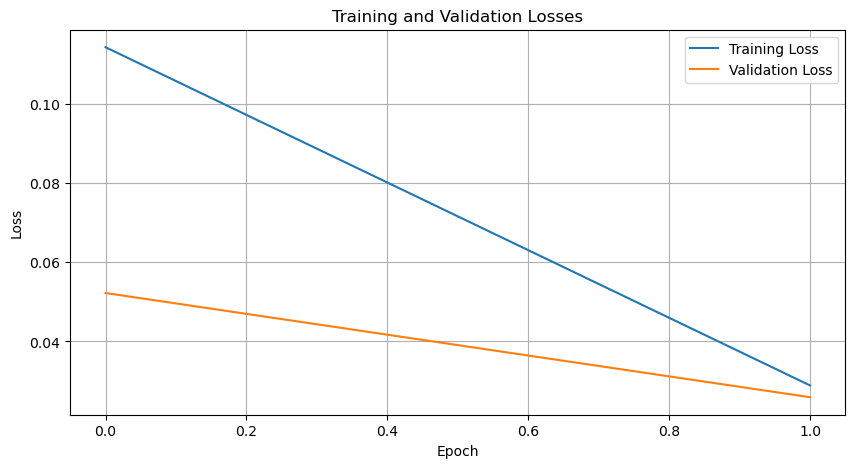

In [10]:
# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('trainvalgraph.png', bbox_inches='tight')
plt.show()

In [11]:
def binary_accuracy(preds, target):
    correct = (preds == target).float()
    acc = correct.sum() / correct.numel()
    return acc

def iou_score(preds, target):
    intersection = (preds & target).sum(dim=(1, 2))
    union = (preds | target).sum(dim=(1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def recall(preds, target):
    true_positive = (preds & target).sum()
    actual_positive = target.sum()
    rec = true_positive / (actual_positive + 1e-6)
    return rec

def precision(preds, target):
    true_positive = (preds & target).sum()
    predicted_positive = preds.sum()
    prec = true_positive / (predicted_positive + 1e-6)
    return prec

def evaluate_model(model, loader, device):
    model.eval()
    with torch.no_grad():
        all_accuracy, all_iou, all_recall, all_precision = [], [], [], []
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).long()
            
            outputs = model(images)['out']
            outputs = torch.sigmoid(outputs)
            outputs = torch.argmax(outputs, dim=1)
            
            if outputs.shape != masks.shape:
                masks = masks.squeeze(1)
                
            all_accuracy.append(binary_accuracy(outputs, masks))
            all_iou.append(iou_score(outputs, masks))
            all_recall.append(recall(outputs, masks))
            all_precision.append(precision(outputs, masks))
        
        mean_accuracy = torch.mean(torch.stack(all_accuracy)).item()
        mean_iou = torch.mean(torch.stack(all_iou)).item()
        mean_recall = torch.mean(torch.stack(all_recall)).item()
        mean_precision = torch.mean(torch.stack(all_precision)).item()
        
        print(f'Accuracy: {mean_accuracy}, IoU: {mean_iou}')
        print(f'Recall: {mean_recall}, Precision: {mean_precision}')
        
    return mean_accuracy, mean_iou, mean_recall, mean_precision

# Llamar a la función de evaluación para el loader de validación o prueba
mean_accuracy, mean_iou, mean_recall, mean_precision = evaluate_model(model, val_loader, device)


Accuracy: 0.9905012249946594, IoU: 0.7156961560249329
Recall: 0.9102287888526917, Precision: 0.8747231960296631


Mean Accuracy: 0.6378527879714966, Mean IoU: 0.6008716821670532
Mean Recall: 0.6378527283668518, Mean Precision: 0.623142421245575
Per-Class Precision: tensor([0.9959, 0.8736, 0.0000])


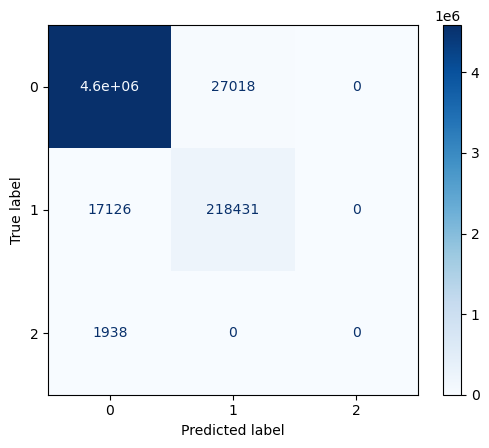

In [12]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def per_class_accuracy(preds, target, num_classes):
    acc = []
    for cls in range(num_classes):
        cls_pred = (preds == cls)
        cls_target = (target == cls)
        correct = (cls_pred & cls_target).sum().float()
        total = cls_target.sum().float()
        acc.append(correct / (total + 1e-6))
    return torch.tensor(acc)

def iou_score(preds, target, num_classes):
    iou = []
    for cls in range(num_classes):
        cls_pred = (preds == cls)
        cls_target = (target == cls)
        intersection = (cls_pred & cls_target).sum().float()
        union = (cls_pred | cls_target).sum().float()
        iou.append(intersection / (union + 1e-6))
    return torch.tensor(iou).mean()

def recall(preds, target, num_classes):
    recall = []
    for cls in range(num_classes):
        cls_pred = (preds == cls)
        cls_target = (target == cls)
        true_positive = (cls_pred & cls_target).sum().float()
        actual_positive = cls_target.sum().float()
        recall.append(true_positive / (actual_positive + 1e-6))
    return torch.tensor(recall).mean()

def precision(preds, target, num_classes):
    precision = []
    for cls in range(num_classes):
        cls_pred = (preds == cls)
        cls_target = (target == cls)
        true_positive = (cls_pred & cls_target).sum().float()
        predicted_positive = cls_pred.sum().float()
        precision.append(true_positive / (predicted_positive + 1e-6))
    return torch.tensor(precision)

def evaluate_model(model, loader, device, num_classes):
    model.eval()
    all_preds, all_masks = [], []
    with torch.no_grad():
        all_accuracy, all_iou, all_recall, all_precision = [], [], [], []
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).long()
            
            outputs = model(images)['out']
            outputs = torch.softmax(outputs, dim=1)  # Aplica softmax para convertir a probabilidades
            preds = torch.argmax(outputs, dim=1)  # Convertimos a clase más probable
            
            if preds.shape != masks.shape:
                masks = masks.squeeze(1)
                
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())
            
            all_accuracy.append(per_class_accuracy(preds, masks, num_classes))
            all_iou.append(iou_score(preds, masks, num_classes))
            all_recall.append(recall(preds, masks, num_classes))
            all_precision.append(precision(preds, masks, num_classes))
        
        mean_accuracy = torch.mean(torch.stack(all_accuracy)).item()
        mean_iou = torch.mean(torch.stack(all_iou)).item()
        mean_recall = torch.mean(torch.stack(all_recall)).item()
        mean_precision = torch.mean(torch.stack(all_precision)).item()
        
        print(f'Mean Accuracy: {mean_accuracy}, Mean IoU: {mean_iou}')
        print(f'Mean Recall: {mean_recall}, Mean Precision: {mean_precision}')
        
        per_class_precisions = torch.mean(torch.stack(all_precision), dim=0)
        print(f'Per-Class Precision: {per_class_precisions}')

        all_preds = np.concatenate(all_preds).flatten()
        all_masks = np.concatenate(all_masks).flatten()
        cm = confusion_matrix(all_masks, all_preds, labels=range(num_classes))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        
    return mean_accuracy, mean_iou, mean_recall, mean_precision, per_class_precisions

# Llamar a la función de evaluación para el loader de validación o prueba
num_classes = n_classes
mean_accuracy, mean_iou, mean_recall, mean_precision, per_class_precisions = evaluate_model(model, val_loader, device, num_classes)
